In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Models

In [2]:
# load all models
rf = pickle.load(open('../models/rf.pickle', 'rb'))
lr = pickle.load(open('../models/lasso.pickle', 'rb'))
xgb = pickle.load(open('../models/xgb.pickle', 'rb'))
knn = pickle.load(open('../models/knn.pickle', 'rb'))
mpr = pickle.load(open('../models/mpr.pickle', 'rb'))

[18:37:23] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


/Users/nikhilbhargava/opt/anaconda3/envs/mids-python/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Load Test Data

#### Regular Data

In [3]:
# regular data
us = pd.read_csv('../data/processed/us-test.csv')
madrid = pd.read_csv('../data/processed/madrid-test.csv')
london = pd.read_csv('../data/processed/london-test.csv')
paris = pd.read_csv('../data/processed/paris-test.csv')

In [4]:
# create X & y dataframes
y_test = us.log_price
X_test = us.drop(columns=['log_price'])

madrid_y = madrid.log_price
madrid_X = madrid.drop(columns=['log_price'])

london_y = london.log_price
london_X = london.drop(columns=['log_price'])

paris_y = paris.log_price
paris_X = paris.drop(columns=['log_price'])

international_X = pd.concat([madrid_X, london_X, paris_X])
international_y = pd.concat([madrid_y, london_y, paris_y])

#### Standardized + PCA Data

In [5]:
# regular data
knn_us = pd.read_csv('../data/processed/knn/us_test_pca.csv')
knn_madrid = pd.read_csv('../data/processed/knn/madrid_test_pca.csv')
knn_london = pd.read_csv('../data/processed/knn/london_test_pca.csv')
knn_paris = pd.read_csv('../data/processed/knn/paris_test_pca.csv')
knn_intl = pd.read_csv('../data/processed/knn/eur_test_pca.csv')

In [6]:
# drop unnamed columns
knn_us.drop(columns=['Unnamed: 0'], inplace=True)
knn_madrid.drop(columns=['Unnamed: 0'], inplace=True)
knn_london.drop(columns=['Unnamed: 0'], inplace=True)
knn_paris.drop(columns=['Unnamed: 0'], inplace=True)
knn_intl.drop(columns=['Unnamed: 0'], inplace=True)

#### Make Predictions

In [7]:
# make predictions
us_rf = rf.predict(X_test)
us_lr = lr.predict(X_test)
us_xgb = xgb.predict(X_test)
us_knn = knn.predict(knn_us)
us_mpr = mpr.predict(X_test)

In [8]:
model_dict = {'LR': us_lr, 'KNN': us_knn, 'RF': us_rf, 'XGB': us_xgb, 'MPR': us_mpr}
model_name = list(model_dict.keys())
model_preds = list(model_dict.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [180]:
# plot prediction distirbutions and residuals
def plot_predictions(ax, y, pred, model_name, colors):
    ax.hist(y, bins=30, label='Listing Prices', color='lightgrey', alpha = 0.8)
    ax.hist(pred, bins=30, label='Listing Preds', color=colors, alpha = 0.5)
    ax.set_xlabel('Log Price', fontsize=15)
    ax.set_ylabel('Number of Listings', fontsize=15)
    ax.set_title(f'US Prices vs. {model_name} Predictions'.format(model_name), fontsize=17)
    ax.tick_params(axis="y",direction="in", pad=-31)
    ax.set_ylim(0, 2500)
    ax.set_yticks(ax.get_yticks()[1:-1])
    ax.legend(fontsize=13)
    
def plot_residuals(ax, y, pred, model_name, colors):
    
    sign = np.sign(np.exp(y)-np.exp(pred))
    residuals = sign * np.log(np.abs(np.exp(y) - np.exp(pred)))
    ax.hist(residuals, bins=30, label='Residuals', color=colors, alpha = 0.5)
    ax.set_xlabel('Residual Values', fontsize=15)
    ax.set_ylabel('Number of Listings', fontsize=15)
    ax.set_title(f'US {model_name} Residual Distribution'.format(model_name), fontsize=17)
    ax.tick_params(axis="y",direction="in", pad=-31)
    ax.set_ylim(0, 4500)
    ax.set_yticks(ax.get_yticks()[1:-1])

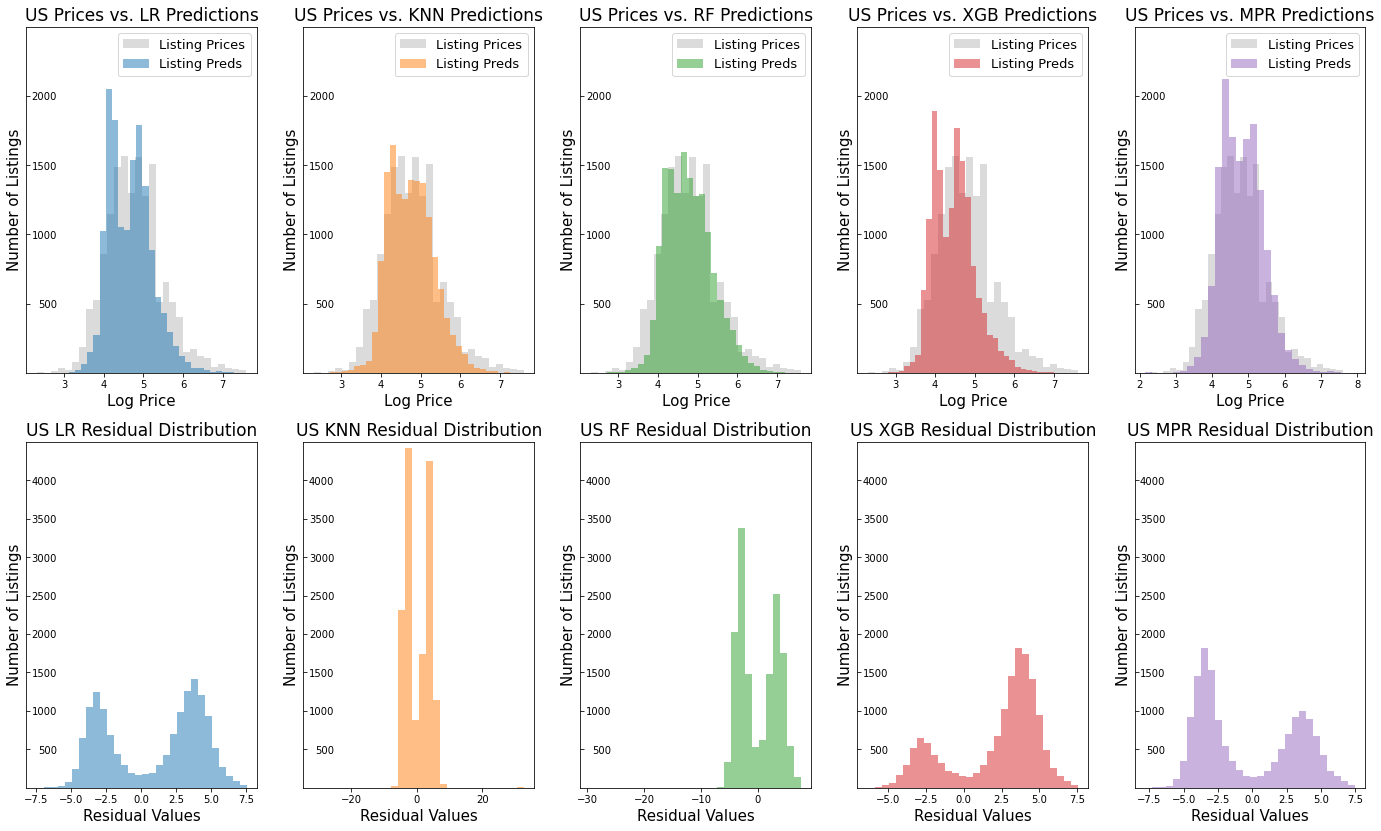

In [181]:
fig, axs = plt.subplots(2,5,figsize = (24, 14))
for i, data in enumerate(model_preds):
    plot_predictions(axs[0, i], y_test, data, model_name[i], colors[i])
    
for i, data in enumerate(model_preds):
    plot_residuals(axs[1, i], y_test, data, model_name[i], colors[i])

### International Predictions

In [11]:
intl_rf = rf.predict(international_X)
intl_lr = lr.predict(international_X)
intl_xgb = xgb.predict(international_X)
intl_knn = knn.predict(knn_intl)
intl_mpr = mpr.predict(international_X)

In [12]:
# adjust predictions for cost of living
int_col = 100/90.317413
intl_rf = np.log(np.exp(intl_rf / int_col))
intl_lr = np.log(np.exp(intl_lr / int_col))
intl_xgb = np.log(np.exp(intl_xgb / int_col))
intl_knn = np.log(np.exp(intl_knn / int_col))
intl_mpr = np.log(np.exp(intl_mpr / int_col))

In [13]:
int_model_dict = {'LR': intl_lr, 'KNN': intl_knn, 'RF': intl_rf, 'XGB': intl_xgb, 'MPR': intl_mpr}
int_model_name = list(int_model_dict.keys())
int_model_preds = list(int_model_dict.values())

In [186]:
# plot prediction distirbutions and residuals
def int_plot_predictions(ax, y, pred, model_name, colors):
    ax.hist(y, bins=30, label='Listing Prices', color='lightgrey', alpha = 0.8)
    ax.hist(pred, bins=30, label='Listing Preds', color=colors, alpha = 0.5)
    ax.set_xlabel('Log Price', fontsize = 15)
    ax.set_ylabel('Number of Listings', fontsize = 15)
    ax.set_title(f"Int'l Prices vs. {model_name} Predictions".format(model_name), fontsize = 17)
    ax.tick_params(axis="y",direction="in", pad=-37)
    ax.set_ylim(0, 60000)
    ax.set_yticks(ax.get_yticks()[1:-1])
    ax.legend(fontsize=13)
    
def plot_residuals(ax, y, pred, model_name, colors):
    sign = np.sign(np.exp(y)-np.exp(pred))
    residuals = sign * np.log(np.abs(np.exp(y) - np.exp(pred)))
    ax.hist(residuals, bins=30, label='Residuals', color=colors, alpha = 0.5)
    ax.set_xlabel('Residual Values', fontsize = 15)
    ax.set_ylabel('Number of Listings', fontsize = 15)
    ax.set_title(f'{model_name} Residual Distribution'.format(model_name), fontsize = 17)
    ax.tick_params(axis="y",direction="in", pad=-37)
    ax.set_ylim(0, 60000)
    ax.set_yticks(ax.get_yticks()[1:-1])

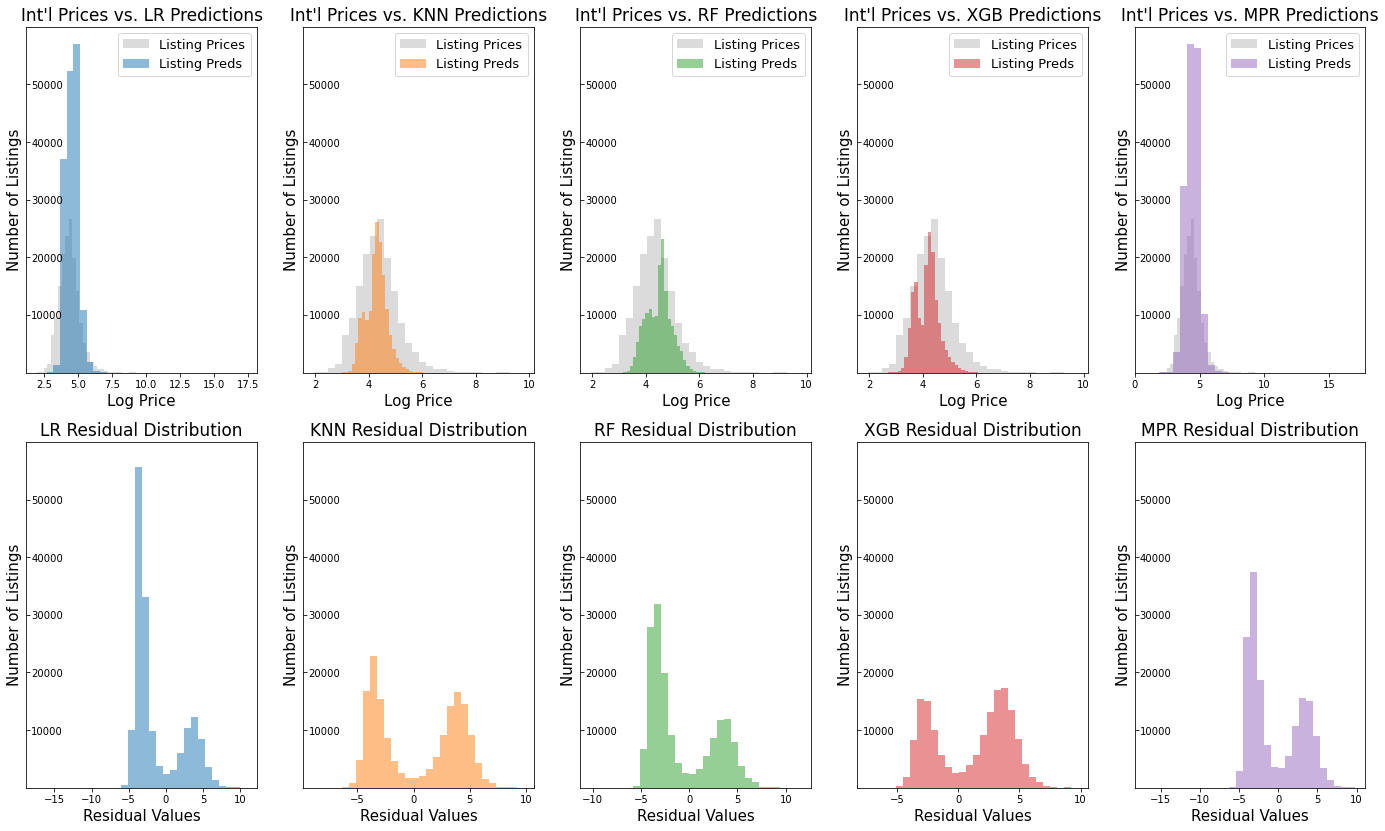

In [187]:
fig, axs = plt.subplots(2,5,figsize = (24, 14))
for i, preds in enumerate(int_model_preds):
    int_plot_predictions(axs[0, i], international_y, preds, int_model_name[i], colors[i])
    
for i, preds in enumerate(int_model_preds):
    plot_residuals(axs[1, i], international_y, preds, int_model_name[i], colors[i])

## Visualize log price

In [24]:
# plot prices across international data
us_prices = np.random.choice(y_test, size=10000)
madrid_prices = np.random.choice(madrid_y, size=10000)
london_prices = np.random.choice(london_y, size=10000)
paris_prices = np.random.choice(paris_y, size=10000)
intl_prices = np.random.choice(international_y, size=10000)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8e4e887a90>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8e4e887a50>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8e4e8923d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8e4e892750>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f8e4d50ec50>}

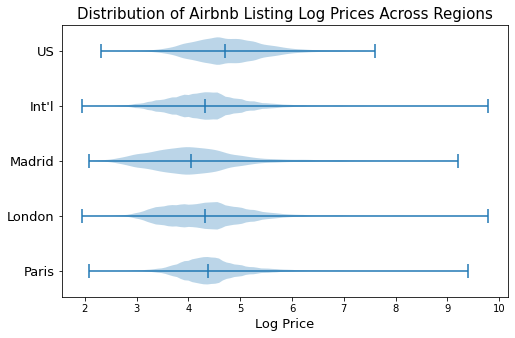

In [59]:
# Combine data
plot_data = list([paris_y, london_y, madrid_y, international_y, y_test])

fig, ax = plt.subplots(figsize=(8,5))

yticklabels = ['Paris', 'London', 'Madrid', "Int'l", 'US']
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(yticklabels, fontsize=13)
ax.set_xlabel('Log Price', fontsize=13)
ax.set_title('Distribution of Airbnb Listing Log Prices Across Regions', fontsize=15)

ax.violinplot(plot_data, vert=False, showmedians=True)